In [2]:
import sys
!{sys.executable} -m pip install biopython

     |████████████████████████████████| 2.3MB 3.3MB/s eta 0:00:01


Learning how to use Biopython
--

In [1]:
from Bio import AlignIO
aln = AlignIO.read('msa.phy', 'phylip')
print(aln)
ex1 = AlignIO.read('ex1.phy', 'fasta')
print(ex1)
ex2 = AlignIO.read('ex2.phy', 'phylip')
print(ex2)

Alignment with 5 rows and 13 columns
AACGTGGCCACAT Alpha
AAGGTCGCCACAC Beta
CAGTTCGCCACAA Gamma
GAGATTTCCGCCT Delta
GAGATCTCCGCCC Epsilon
Alignment with 4 rows and 5 columns
10000 Alpha
11010 Beta
10111 Gamma
00000 Omega
Alignment with 5 rows and 4 columns
1001 Alpha
1000 Beta
0110 Gamma
0120 Delta
0121 Epsilon


In [2]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
print(dm)
dm1 = calculator.get_distance(ex1)
print(dm1)

Alpha	0
Beta	0.23076923076923073	0
Gamma	0.3846153846153846	0.23076923076923073	0
Delta	0.5384615384615384	0.5384615384615384	0.5384615384615384	0
Epsilon	0.6153846153846154	0.3846153846153846	0.46153846153846156	0.15384615384615385	0
	Alpha	Beta	Gamma	Delta	Epsilon
Alpha	0
Beta	0.4	0
Gamma	0.6	0.6	0
Omega	0.19999999999999996	0.6	0.8	0
	Alpha	Beta	Gamma	Omega


In [3]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
# Create a DistanceTreeConstructor object
constructor = DistanceTreeConstructor()
upgmatree = constructor.upgma(dm)

In [4]:
from Bio.Phylo.TreeConstruction import *

scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
constructor = ParsimonyTreeConstructor(searcher)
pars_tree = constructor.build_tree(ex1)
print(pars_tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner3')
        Clade(branch_length=0.32499999999999996, name='Gamma')
        Clade(branch_length=0.07499999999999996, name='Inner2')
            Clade(branch_length=0.25, name='Beta')
            Clade(branch_length=0.15000000000000002, name='Inner1')
                Clade(branch_length=0.09999999999999998, name='Omega')
                Clade(branch_length=0.09999999999999998, name='Alpha')


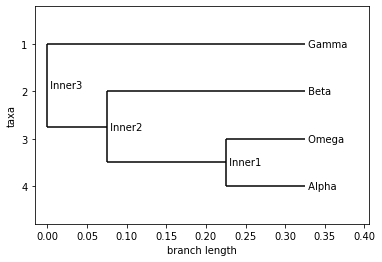

In [6]:
from Bio import Phylo

Phylo.draw(pars_tree)

Loads all functions
--

In [1]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import *
from Bio import Phylo
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import numpy as np

def d_h(s1, s2):
    ''' Hamming distance betweeen two strings
    '''
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def weightT(T):
    ''' input: weighted tree
        output: its weight
    ''' 
    parslen = 0
    for e in T.edges(data=True):
        parslen += e[2]['weight']
    return parslen

def build_complete_graph(data):
    '''input: data = output of AlignIO.read
       output: a weighted complete graph
    '''
    # initializes a graph
    G = nx.Graph()
    # nodes and edges
    seqs = [str(x.seq) for x in list(data)]
    ids  = [x.id for x in list(data)]
    # add edges
    lst_edges = [(ids[u],ids[v],d_h(seqs[u],seqs[v])) for u,v in nx.complete_graph(len(ids)).edges()]
    G.add_weighted_edges_from(lst_edges)
    
    return G

def build_tree_from_complete_graph(G):
    ''' input: G = complete graph, generated by build_complete_graph
        output: a parsimonious tree
    '''
    # for G, maps from ids to indices 
    change_labels = {}
    
    for i in range(len(list(G.nodes()))):
        change_labels[list(G.nodes())[i]] = i
        
    # assign integer labels
    G = nx.relabel_nodes(G, change_labels)
    
    # MST
    T = nx.minimum_spanning_tree(G)
    # number of nodes
    N = T.order()
    # initializes parsimony tree
    Tpars = nx.Graph()
    
    while T.size() > 0:
        # finds leaves in tree
        leaves = [n for n in T.nodes() if T.degree(n)==1]
        # edges connecting leaves to predecessors
        predecessors_edges = [e for e in T.edges(data=True) if e[0] in leaves or e[1] in leaves]
        # predecessors
        predecessors = list(set([e[0] if not(e[0] in leaves) else e[1]for e in predecessors_edges]))
        
        if not(set(leaves) == set(predecessors)):
            # for parsimony tree, uses a leaf also as intermediate node
            # thus needs an edge (of weight 0) from the intermediate node to leaf
            # cannot keep the same label though, add new nodes with label n+N
            self_edges = [(n, n+N, {'weight': 0}) for n in predecessors]
            # adds these edges to the parsimony tree
            Tpars.add_edges_from(predecessors_edges+self_edges)
            # removes edges from MST
            T.remove_edges_from(predecessors_edges)
            
        else:
            # last edge
            le = list(T.edges(data=True))[0]
            edges_toroot = [(le[0],le[1],le[2]), (le[1],le[1]+N,{'weight': 0})] 
            Tpars.add_edges_from(edges_toroot)
            # removes edges from MST
            T.remove_edges_from([list(T.edges())[0]])
            
    leaves = [n for n in Tpars.nodes() if Tpars.degree(n) == 1]
    # this is to make sure that leaves have the smallest index 
    flip_mapping = {}
    for l in leaves:
        if l > N-1:
            # a leaf of the form n+N, say we want l=82 to be 2
            # 2 becomes 82 
            flip_mapping[l-N] = l
            # 82 becomes 2
            flip_mapping[l] = l-N
            
    Tpars = nx.relabel_nodes(Tpars, flip_mapping)    
    
    return Tpars

def dBC(c1, c2, X):
    
    # max for hamming distance
    mind = len(X[0]) + 1
    minxy = []
    for x in c1:
        for y in c2:
            # hamming
            d = d_h(X[x], X[y])
            if d < mind:
                mind = d
                minxy = [(x,y)]
            else:
                if d == mind:
                    minxy.append((x,y))
    return [mind, minxy]
            
def labelled_clustering(X, Z):
    ''' input: X = data that serves as input to compute Z
               Z = dendogram
    '''
    
    # number of points to be clustered
    n = np.shape(Z)[0]+1
    
    # cluster membership
    C = {}
    # labels
    L = {}
    # tree
    T = nx.Graph()
    # Z is (n-1)x4
    for i in range(n-1):
        c1 = int(Z[i,0])
        c2 = int(Z[i,1])
        if not(c1 in C.keys()):
            # leaf
            C[c1] = [c1]
        if not(c2 in C.keys()):
            # leaf
            C[c2] = [c2]

        C[n+i] = C[c1]+C[c2]     
        # after agglomeration, sets up labels
        argmin = dBC(C[c1], C[c2], X)[1]
        # argmin could contain several options
        L[c1] = argmin[0][0]
        L[c2] = argmin[0][1]
        # builds labelled tree 
        T.add_edges_from([(c1,n+i),(c2,n+i)])
        
    # last label, n + (n-2)
    L[n+n-2] = L[n+n-3]
    
    Tweight = nx.Graph()
    for e in T.edges():
        weight = (d_h(X[L[e[0]]],X[L[e[1]]]))
        Tweight.add_edges_from([(e[0],e[1],{'weight': weight})])
        
    return Tweight, L

def find_clusters_frompars(G, noiter, tree_root): 
    '''
    '''
    G = G.to_undirected()
    if tree_root == None:
        prev_nodes = [list(G.nodes())[0]]
    else:
        prev_nodes = [tree_root]
    
    # leaves
    leaves = [n for n in G.nodes() if G.degree(n) == 1]
    
    for i in range(noiter):
        next_edges = [e for e in G.edges() if e[0] in prev_nodes or e[1] in prev_nodes ]
        next_nodes = []
        # find edges out from root(s)
        for e in next_edges:
            if not(e[0] in prev_nodes):
                next_nodes.append(e[0])
            if not(e[1] in prev_nodes):
                next_nodes.append(e[1])
        # disconnects the descendants
        G.remove_edges_from(next_edges)
        # removes the ancestors if they are not leaves
        G.remove_nodes_from([n for n in prev_nodes if not(n in leaves)])
        # updates roots
        prev_nodes = next_nodes
    # connected components
    ccs = [G.subgraph(c) for c in nx.connected_components(G)]
    
    clusters = []
    for cc in ccs:

        if cc.order() > 1:
            #cce = [e for e in G.edges() if e[0] in cc and e[1] in cc]
            #ccG = ccG.add_edges_from(cce)
            ccn = [n for n in cc.nodes() if cc.degree(n)==1]
            clusters.append(ccn)
        else:
            clusters.append(list(cc.nodes()))
        
    return clusters

def compute_pairs(labels):
    '''
    '''
    Lpairs = []
    
    labels_newformat = [0 for x in range(sum([len(s) for s in labels]))]
    for s in labels:
        for idx in s:
            labels_newformat[idx] = labels.index(s)
    
    clus_list = set(labels_newformat)
    for clus in clus_list: 
        s = [i for i, x in enumerate(labels_newformat) if x == clus]
        for i in range(len(s)):
            for j in range(i+1,len(s)):
                #[set(i) for i in itertools.combinations(s, 2)]
                Lpairs.extend([(s[i],s[j])])
    return Lpairs

def Fmeasure(labels,truthlabels):
    '''
    '''
    Pclus = set(compute_pairs(labels))
    Ptrue = set(compute_pairs(truthlabels))
    #print(len(Pclus))
    #print(len(Ptrue))
    a = len(Pclus.intersection(Ptrue))
    b = len(Pclus-Ptrue)
    c = len(Ptrue-Pclus)
    #print(a,b,c)
    F = (2*a)/(2*a+b+c)
    return F

Parsimonious trees
--

In [2]:
# reads the file
usflu_data = AlignIO.read('usflu.fasta', 'fasta')
print(usflu_data)
# retrieves sequences and ids
seqs_usflu = [str(x.seq) for x in list(usflu_data)]
ids_usflu = [x.id for x in list(usflu_data)]

Alignment with 80 rows and 1701 columns
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013200
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013781
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012128
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013613
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012160
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012272
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY010988
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012288
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012568
atgaagactatcattgctttgagctacatttcatgtctggtttt...tga CY013016
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012480
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY010748
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY011528
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY017291
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012504
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY009476


Method 1:neighbour joining (NJ)

In [3]:
# computes distance
dist_usflu = DistanceCalculator('identity').get_distance(usflu_data)
print(dist_usflu)

# creates NJ tree
nj_tree_usflu = DistanceTreeConstructor().nj(dist_usflu)

CY013200	0
CY013781	0.0023515579071134995	0
CY012128	0.008230452674897082	0.008230452674897082	0
CY013613	0.0023515579071134995	0.0011757789535566943	0.008230452674897082	0
CY012160	0.0023515579071134995	0.0023515579071134995	0.008230452674897082	0.0023515579071134995	0
CY012272	0.003527336860670194	0.003527336860670194	0.009406231628453887	0.003527336860670194	0.003527336860670194	0
CY010988	0.0064667842445620405	0.0064667842445620405	0.012345679012345734	0.0064667842445620405	0.0064667842445620405	0.004115226337448541	0
CY012288	0.004115226337448541	0.004115226337448541	0.009994121105232234	0.004115226337448541	0.004115226337448541	0.0017636684303351524	0.004703115814226888	0
CY012568	0.004703115814226888	0.004703115814226888	0.010582010582010581	0.004703115814226888	0.004703115814226888	0.0023515579071134995	0.0029394473838918467	0.0029394473838918467	0
CY013016	0.005878894767783693	0.005878894767783693	0.011757789535567276	0.005878894767783693	0.005878894767783693	0.003527336860670

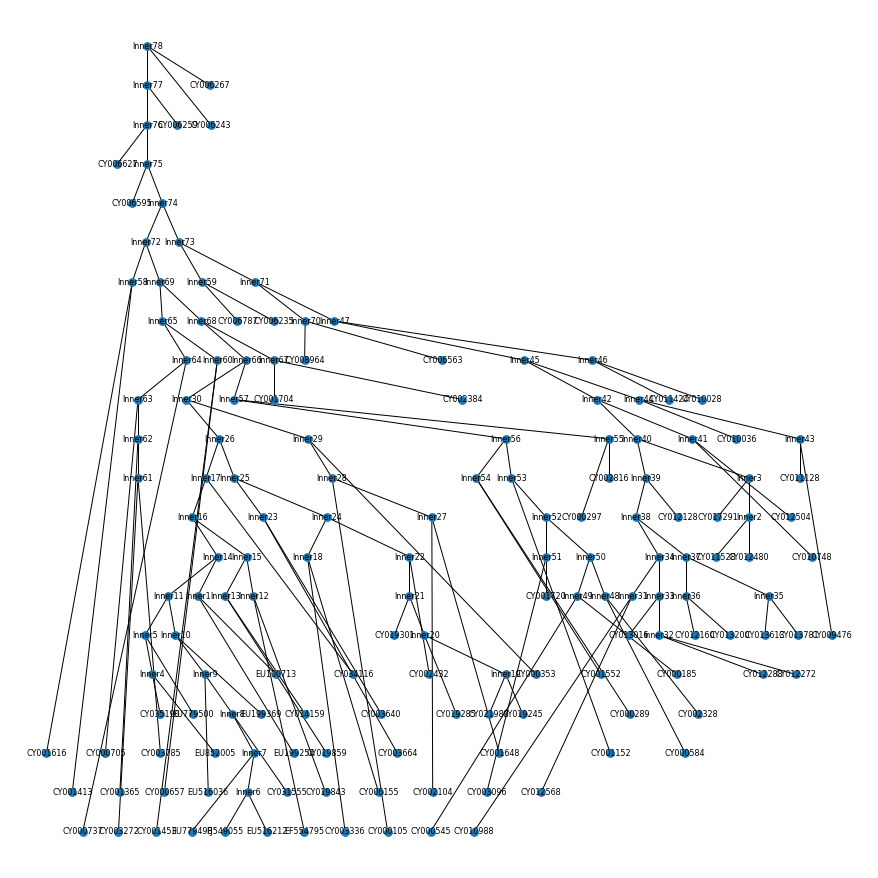

In [4]:
G_usflu = Phylo.to_networkx(nj_tree_usflu)

# twopi, dot, circo
pos = graphviz_layout(G_usflu, prog="dot")

# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(G_usflu, pos, with_labels = True, node_size=60,font_size=8)
plt.show()

Method 2: Parsimony

In [5]:
scorer_usflu = ParsimonyScorer()
searcher_usflu = NNITreeSearcher(scorer_usflu)
# builds the tree from scratch if second argument is empty, 
# otherwise second argument is the starting tree (e.g. nj_tree_usflu)
constructor = ParsimonyTreeConstructor(searcher_usflu)
pars_tree_usflu = constructor.build_tree(usflu_data)
scorer_usflu.get_score(pars_tree_usflu, usflu_data)

543

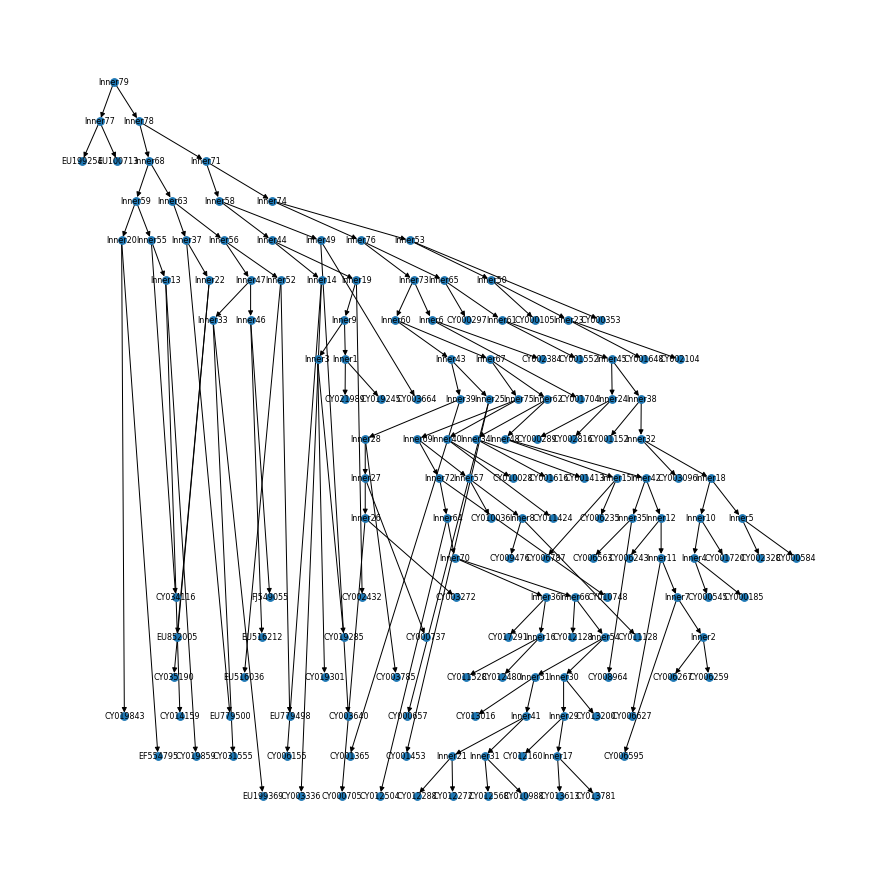

In [6]:
Gpars_usflu = Phylo.to_networkx(pars_tree_usflu)

# twopi, dot, circo
pos2 = graphviz_layout(Gpars_usflu, prog="dot")

# larger figure size
plt.figure(figsize=(12,12)) 
nx.draw(Gpars_usflu, pos2, with_labels = True, node_size=60,font_size=8)
plt.show()

Method 3: start with NJ and optimize parsimony

In [7]:
scorer_usflu_fromnj = ParsimonyScorer()
searcher_usflu_fromnj = NNITreeSearcher(scorer_usflu_fromnj)
# builds the tree from scratch if second argument is empty, 
# otherwise second argument is the starting tree (e.g. nj_tree_usflu)
constructor_fromnj = ParsimonyTreeConstructor(searcher_usflu_fromnj, nj_tree_usflu)
pars_tree_usflu_fromnj = constructor_fromnj.build_tree(usflu_data)
scorer_usflu_fromnj.get_score(pars_tree_usflu_fromnj, usflu_data)

540

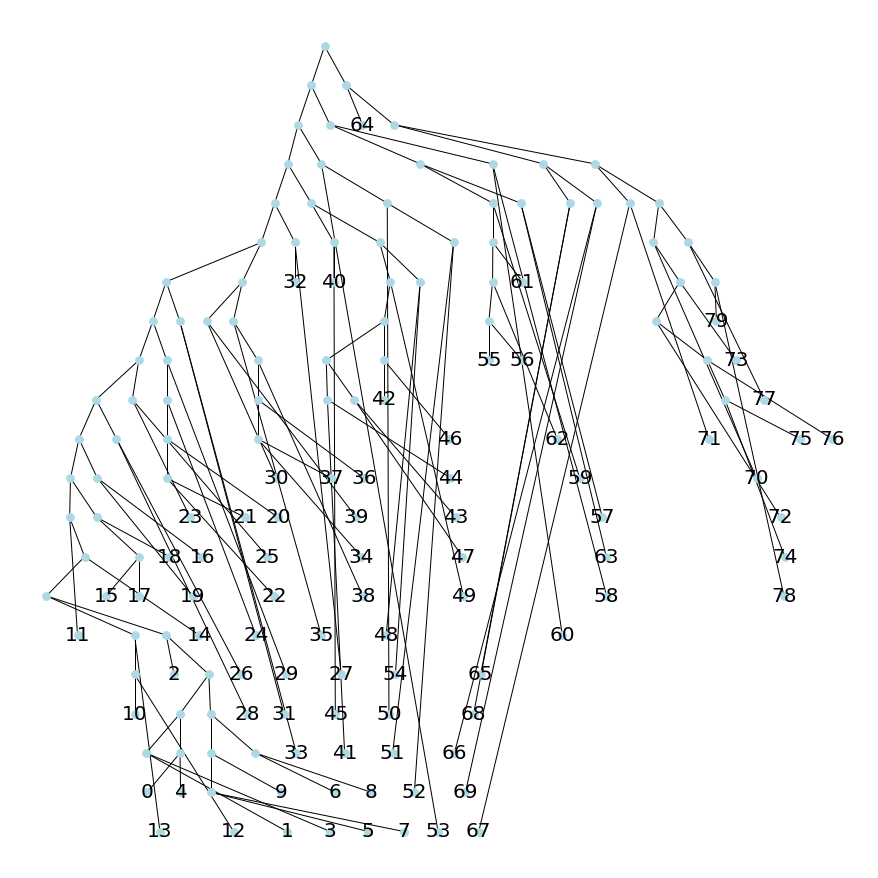

In [8]:
Gpars_usflu_fromnj = Phylo.to_networkx(pars_tree_usflu_fromnj).to_undirected()
current_nodes = list(Gpars_usflu_fromnj)

mapping = {}
for i in range(len(current_nodes)):
    # maps nodes with ids and indices
    if Gpars_usflu_fromnj.degree(current_nodes[i]) == 1: 
        mapping[current_nodes[i]] = ids_usflu.index(current_nodes[i].name)
    
# twopi, dot, circo
pos3 = graphviz_layout(Gpars_usflu_fromnj, prog="dot")

# larger figure size
plt.figure(figsize=(12,12)) 

nx.draw(Gpars_usflu_fromnj, pos3, with_labels = False, node_size=60, node_color='lightblue')
# add labels to the leaves
nx.draw_networkx_labels(Gpars_usflu_fromnj, pos3, mapping, font_size=20)

plt.show()

Built from MST
--

In [2]:
# reads the file
usflu_data = AlignIO.read('usflu.fasta', 'fasta')
print(usflu_data)
# retrieves sequences and ids
seqs_usflu = [str(x.seq) for x in list(usflu_data)]
ids_usflu = [x.id for x in list(usflu_data)]

# weight of mst
Tmst = nx.minimum_spanning_tree(build_complete_graph(usflu_data))
print(weightT(Tmst))

# parsimony from mst
Tpars = build_tree_from_complete_graph(build_complete_graph(usflu_data))
nx.is_tree(Tpars), len([n for n in Tpars.nodes() if Tpars.degree(n)==1]), weightT(Tpars)

Alignment with 80 rows and 1701 columns
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013200
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013781
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012128
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY013613
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012160
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012272
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY010988
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012288
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012568
atgaagactatcattgctttgagctacatttcatgtctggtttt...tga CY013016
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012480
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY010748
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY011528
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY017291
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY012504
atgaagactatcattgctttgagctacattttatgtctggtttt...tga CY009476


(True, 80, 671)

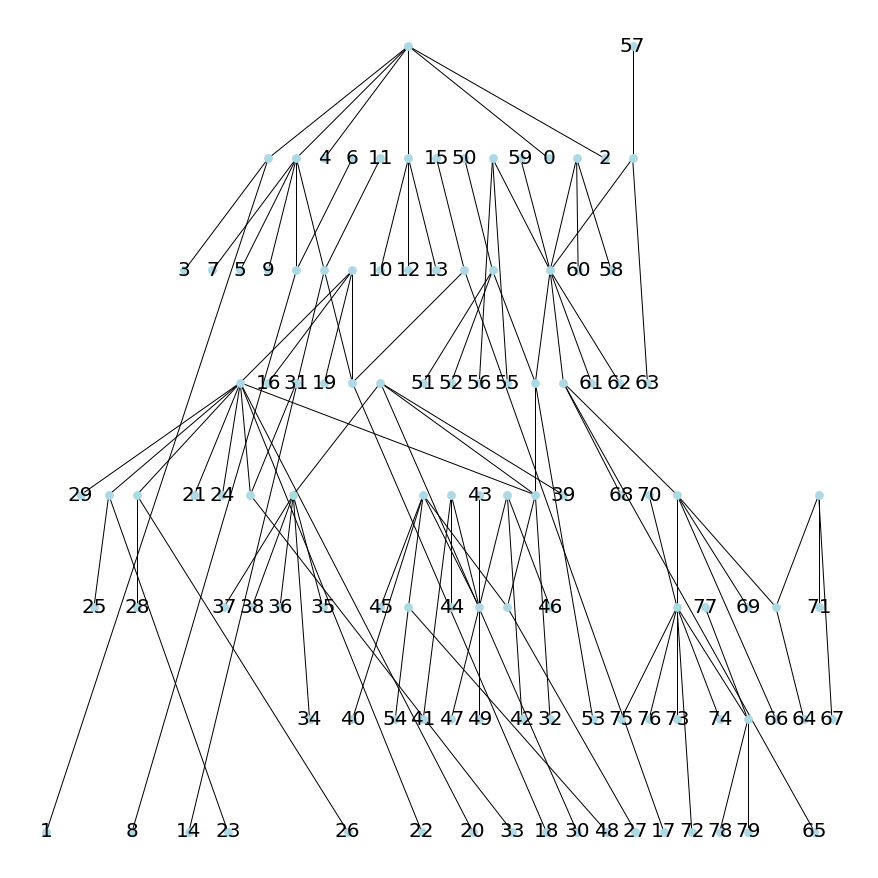

In [3]:
# plots
leaves = [n for n in Tpars.nodes() if Tpars.degree(n) == 1]

mapping = {}
for i in range(len(leaves)):
    mapping[leaves[i]] = leaves[i]

# twopi, dot, circo
pos4 = graphviz_layout(Tpars, prog="dot")

# larger figure size
plt.figure(figsize=(12,12)) 
nx.draw(Tpars, pos4, with_labels = False, node_size=60,font_size=15, node_color='lightblue')
nx.draw_networkx_labels(Tpars, pos4, mapping, font_size=20)
plt.show()

Hierarchical clustering
--

988


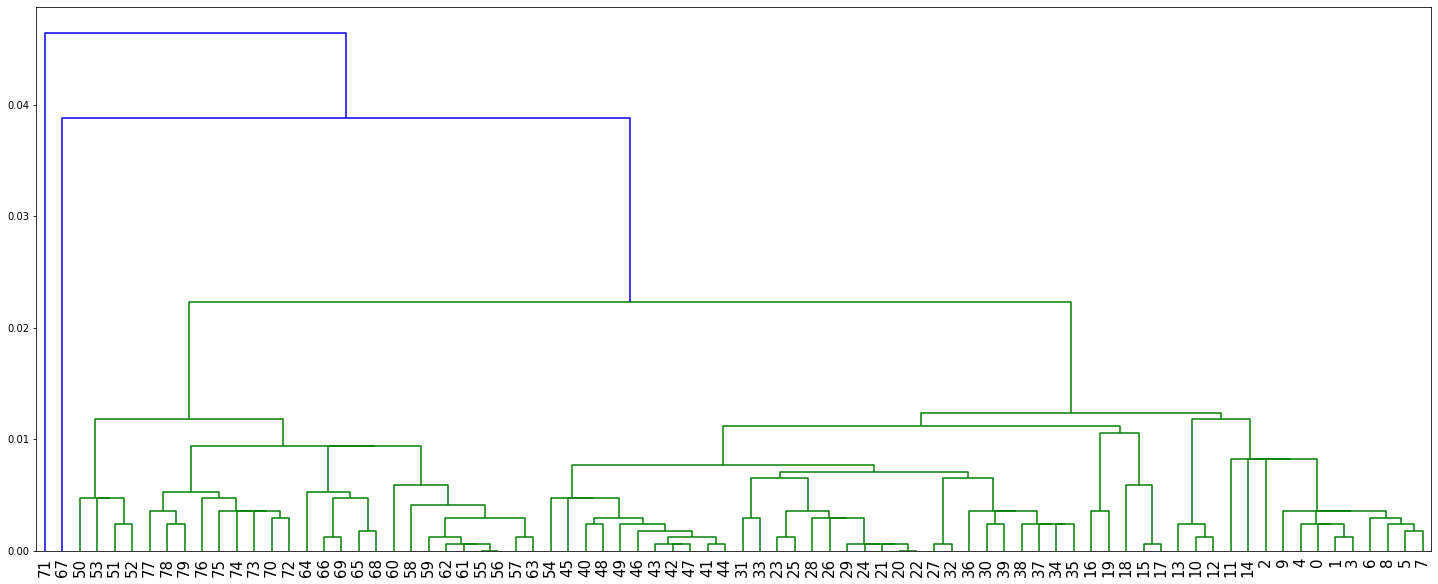

In [14]:
# reads the file
usflu_data = AlignIO.read('usflu.fasta', 'fasta')
seqs_usflu = [str(x.seq) for x in list(usflu_data)]
ids_usflu = [x.id for x in list(usflu_data)]

alphabet = set([y for x in seqs_usflu for y in x])

le = preprocessing.LabelEncoder()
le.fit(list(alphabet))

X = []
for s in seqs_usflu:
    let = list(le.transform([x for x in s]))
    X.append(let)

Z = sch.linkage(X,method='single',metric='Hamming')

# larger figure size
plt.figure(figsize=(25,10)) 
dend = sch.dendrogram(Z, leaf_font_size=15, 
                      #truncate_mode='lastp',  # show only the last p merged clusters
                      #p=12,  # show only the last p merged clusters
                     )

Zlab, L = labelled_clustering(X, Z)
# 988 before 
print(weightT(Zlab))

In [15]:
len(X[0])

1701

Small examples: example 1

47

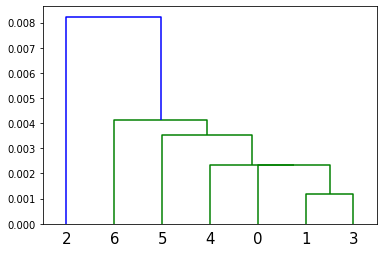

In [15]:
N = 7
X1 = []

for s in seqs_usflu[0:N]:
    let = list(le.transform([x for x in s]))
    X1.append(let)

Z1 = sch.linkage(X1, method='single', metric='Hamming')
dend1 = sch.dendrogram(Z1, leaf_font_size=15)

Zlab1, L1 = labelled_clustering(X1, Z1)
weightT(Zlab1)

Small examples: example 2

65

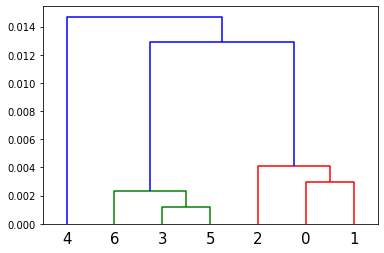

In [16]:
N = 7
X2 = []

for s in seqs_usflu[N:2*N]:
    let = list(le.transform([x for x in s]))
    X2.append(let)

Z2 = sch.linkage(X2, method='single', metric='Hamming')
dend2 = sch.dendrogram(Z2, leaf_font_size=15)

Zlab2, L2 = labelled_clustering(X2, Z2)
weightT(Zlab2)

Small examples: example 3

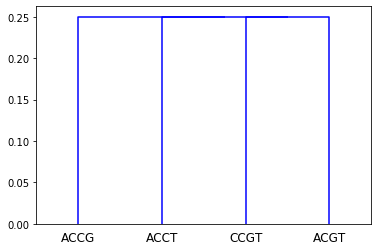

3
3
{0: 0, 2: 2, 1: 1, 4: 2, 3: 3, 5: 1, 6: 1}


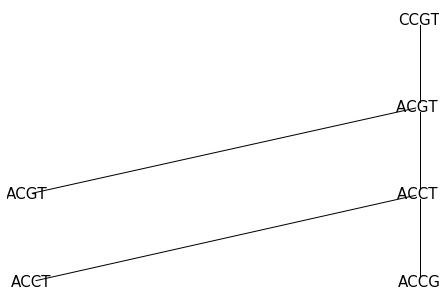

In [18]:
# cleans data for clustering
le3 = preprocessing.LabelEncoder()
le3.fit(["A", "C", "G", "T"])

seqs3 = ['CCGT','ACCT','ACGT','ACCG']

X3 = []
for s in seqs3:
    let = list(le3.transform([x for x in s]))
    X3.append(let)

# clustering and dendogram    
Z3 = sch.linkage(X3,method='single',metric='Hamming')

dend3 = sch.dendrogram(Z3, labels=seqs3)
plt.show()

# complete graph
Gc = nx.Graph()
# add edges
lst_edges = [(u,v,d_h(seqs3[u],seqs3[v])) for u,v in nx.complete_graph(len(seqs3)).edges()]
Gc.add_weighted_edges_from(lst_edges)
T = nx.minimum_spanning_tree(Gc)
print(weightT(T))

Zlab3, L3 = labelled_clustering(X3, Z3)
print(weightT(Zlab3))
print(L3)

mapping = {}
for i in range(len(L3)):
    if i < 4:
        mapping[i] = seqs3[L3[i]]
    else:
        mapping[i] = seqs3[L3[i]] + ' '

Zlab3 = nx.relabel_nodes(Zlab3, mapping)

pos5 = graphviz_layout(Zlab3, prog="dot")

# larger figure size
# plt.figure(figsize=(12,12)) 
nx.draw(Zlab3, pos5, with_labels = True, node_size=60,font_size=15, node_color='white')
plt.show()

F-score
--

We need clusters from above trees. This is for the dendogram.

In [16]:
fc = fcluster(Z, t=0.011, criterion='distance')
len(set(fc))

8

We need clusters from above trees. This is for the parsimonious trees.

In [21]:
clusterings = []
# find clusters within parsimonious trees
for iters in [[2, 2, 1, 0.02], [3, 3, 1, 0.011]]:
    print(iters)
    # Gpars_usflu 
    ct1 = find_clusters_frompars(Gpars_usflu, iters[0], None)
    ct1_label = []
    for ct in ct1:
        ct1_label.append([ids_usflu.index(n.name) for n in ct])
    # Gpars_usflu_fromnj
    ct2 = find_clusters_frompars(Gpars_usflu_fromnj, iters[1], None)
    ct2_label = []
    for ct in ct2:
        ct2_label.append([ids_usflu.index(n.name) for n in ct])
    # Tpars
    # CAUTIOUS ABOUT ROOT
    ct3_label = find_clusters_frompars(Tpars,iters[2], 80)
    
    # Z/Zlab 
    fc = fcluster(Z, t=iters[3], criterion='distance')
    fc_label = {}
    for i in range(len(set(fc))):
        fc_label[i] = []
    fcs = list(fc)
    for i in range(len(fcs)):
        fc_label[fcs[i]-1]+= [i] 
        
    for ct, ct_label in zip([ct1, ct2, ct3_label, list(fc_label.values())],[ct1_label, ct2_label, ct3_label, list(fc_label.values())]):
        print('cluster number:', len(ct))
        # check that all the leaves are accounted for
        cnt = []
        for ctt in ct:
            cnt += ctt
        print(len(set(cnt)))
    clusterings.append([ct1_label, ct2_label, ct3_label, list(fc_label.values())])     
    

[2, 2, 1, 0.02]
cluster number: 4
80
cluster number: 4
80
cluster number: 6
80
cluster number: 4
80
[3, 3, 1, 0.011]
cluster number: 6
80
cluster number: 7
80
cluster number: 6
80
cluster number: 8
80


In [22]:
fscores = np.zeros((4,4))

for i in range(4):
    for j in range(i+1, 4):
        fscores[i,j] = Fmeasure(clusterings[0][i], clusterings[0][j])
        fscores[j,i] = Fmeasure(clusterings[1][i], clusterings[1][j])
        
fscores

array([[0.        , 0.85668363, 0.70066424, 0.7736405 ],
       [0.9177755 , 0.        , 0.58576206, 0.85793358],
       [0.56554398, 0.50764526, 0.        , 0.60105112],
       [0.53333333, 0.56668205, 0.45138269, 0.        ]])